# Part A

---

# Crime Data Analysis and Visualization Using Apache Spark

### Introduction
This notebook performs **analysis and visualization** on crime data using **Apache Spark** for data processing and **matplotlib**/**seaborn** for data visualization. The dataset contains detailed street-level crime records for various regions and periods.

---

### Importing Required Libraries and Initializing Spark Session

In this section, we import the necessary libraries, including `pyspark` for Spark operations, `pandas` for data handling, and `matplotlib` and `seaborn` for plotting. We then initialize the Spark session to enable data processing.

---

### Loading the Dataset

Here, we load the dataset files matching a specific naming pattern from the `datasetA` directory. This pattern matches all 2022 street-level crime data files, allowing us to process multiple files as a single DataFrame.

* `header=True` indicates that the first row contains column headers.
* `inferSchema=True` enables automatic detection of data types for each column.

After loading, we display the first few rows and the schema to understand the structure of the data.


In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.functions import row_number, col, asc, desc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder \
    .appName("CrimeDataLoader") \
    .getOrCreate()

In [2]:
# Revised path pattern to load all matching files
df = spark.read.csv(
    "datasetA/2022-*-*-street.csv",  # Pattern to match all files in the datasetA directory
    header=True,
    inferSchema=True
)

# Show the first few rows
df.show(5)

# Display the schema
df.printSchema()

+--------------------+-------------------+-----------+------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+
|            Crime ID|              Month|Reported by|Falls within|Longitude| Latitude|            Location|LSOA code|   LSOA name|          Crime type|Last outcome category|Context|
+--------------------+-------------------+-----------+------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+
|b93c5583a3adce8a0...|2022-08-01 00:00:00|Kent Police| Kent Police| 0.973355|51.260972|On or near Lower ...|E01023987|Ashford 001B|            Burglary| Investigation com...|   NULL|
|330e17b2dc5af6854...|2022-08-01 00:00:00|Kent Police| Kent Police| 0.963316|51.258906|On or near New Fo...|E01023987|Ashford 001B|Criminal damage a...| Investigation com...|   NULL|
|794686e451d00c2c8...|2022-08-01 00:00:00|Kent Police| Kent Police| 0.958126|51.25956

### Defining County Mapping for Police Forces

In this cell, we create a mapping between police force names and their corresponding counties. Using this mapping, we add a new column called `County` to the DataFrame by transforming the `Reported by` column. For each record, the `Reported by` values are mapped to their respective county names (e.g., "Derbyshire Constabulary" is mapped to "Derbyshire"). An `otherwise(None)` clause is used to handle any entries that do not match the defined mapping. 

Finally, we display the distinct values of the `Reported by` and `County` columns to verify the mapping accuracy.


In [3]:
# Define mapping for police forces to counties
county_mapping = {
    "Derbyshire Constabulary": "Derbyshire",
    "Kent Police": "Kent",
    "Leicestershire Police": "Leicestershire"
}

# Add a County column by mapping 'Reported by' values to the corresponding county
df = df.withColumn(
    "County",
    F.when(F.col("Reported by") == "Derbyshire Constabulary", "Derbyshire")
     .when(F.col("Reported by") == "Kent Police", "Kent")
     .when(F.col("Reported by") == "Leicestershire Police", "Leicestershire")
     .otherwise(None)  # Handle any unexpected values
)

# Show the DataFrame to verify the results
df.select("Reported by", "County").distinct().show()

+--------------------+--------------+
|         Reported by|        County|
+--------------------+--------------+
|         Kent Police|          Kent|
|Leicestershire Po...|Leicestershire|
|Derbyshire Consta...|    Derbyshire|
+--------------------+--------------+



### Registering DataFrame as SQL View and Counting Crimes per County

This cell registers the `df` DataFrame as a temporary SQL view named `crime_data`, allowing us to run SQL queries on it. We then write a SQL query to calculate the total number of crimes reported in each county for the year 2022. The query groups the data by `County` and counts the total crimes for each, ordering the results in descending order by crime count. The final result is displayed using `show()` to verify the output.


In [4]:
# Register the DataFrame as a SQL temporary view
df.createOrReplaceTempView("crime_data")

# Write the SQL query to count the number of crimes per county
crime_count_query = """
SELECT County, COUNT(*) AS total_crimes
FROM crime_data
WHERE YEAR(Month) = 2022
GROUP BY County
ORDER BY total_crimes DESC
"""

# Execute the query
crime_count_df = spark.sql(crime_count_query)

# Show the results
crime_count_df.show()


+--------------+------------+
|        County|total_crimes|
+--------------+------------+
|          Kent|      200945|
|Leicestershire|      115179|
|    Derbyshire|      110805|
+--------------+------------+



### Analyzing Monthly Crime Data and Identifying Peak Crime Months

This cell performs an in-depth analysis of the crime data on a monthly basis for each county. First, we register the DataFrame as a SQL view named `crime_data` to allow SQL querying. We then run a SQL query to count the total number of crimes per month for each county in 2022, grouping by county and month and ordering the results for easier interpretation.

To identify crime patterns, we define two window specifications: one for ranking the highest crime months and another for the lowest. Using these specifications, we create two DataFrames:
- `highest_month_df`: Lists the month with the highest number of crimes for each county.
- `lowest_month_df`: Lists the month with the lowest number of crimes for each county.

Finally, we join these DataFrames on the `County` column to generate `result_df`, which displays the highest and lowest crime months for each county. The results are shown with `show()`, followed by displaying the full monthly crime data in `monthly_crime_df` for further insights.


In [5]:
# Ensure the DataFrame is registered as a SQL view
df.createOrReplaceTempView("crime_data")

# Query to calculate total crimes per month for each county
monthly_crime_query = """
SELECT County, 
       MONTH(Month) AS Month, 
       COUNT(*) AS total_crimes
FROM crime_data
WHERE YEAR(Month) = 2022
GROUP BY County, MONTH(Month)
ORDER BY County, Month
"""

# Execute the query
monthly_crime_df = spark.sql(monthly_crime_query)

# Define a window partitioned by County and ordered by total_crimes
windowSpecHigh = Window.partitionBy("County").orderBy(desc("total_crimes"))
windowSpecLow = Window.partitionBy("County").orderBy(asc("total_crimes"))

# Add columns to identify the highest and lowest crime months for each county
highest_month_df = monthly_crime_df.withColumn("rank_high", row_number().over(windowSpecHigh)) \
                                   .filter(col("rank_high") == 1) \
                                   .select("County", "Month", "total_crimes") \
                                   .withColumnRenamed("Month", "Highest_Crime_Month") \
                                   .withColumnRenamed("total_crimes", "Highest_Total_Crimes")

lowest_month_df = monthly_crime_df.withColumn("rank_low", row_number().over(windowSpecLow)) \
                                  .filter(col("rank_low") == 1) \
                                  .select("County", "Month", "total_crimes") \
                                  .withColumnRenamed("Month", "Lowest_Crime_Month") \
                                  .withColumnRenamed("total_crimes", "Lowest_Total_Crimes")

# Join the highest and lowest crime month data with the main DataFrame
result_df = highest_month_df.join(lowest_month_df, on="County", how="inner")

# Show the results
result_df.show()

# Display the total number of crimes for each county by month
monthly_crime_df.orderBy("County", "Month").show()

+--------------+-------------------+--------------------+------------------+-------------------+
|        County|Highest_Crime_Month|Highest_Total_Crimes|Lowest_Crime_Month|Lowest_Total_Crimes|
+--------------+-------------------+--------------------+------------------+-------------------+
|    Derbyshire|                  5|               10140|                12|               8008|
|          Kent|                  8|               18365|                12|              14976|
|Leicestershire|                  8|               10373|                 2|               8482|
+--------------+-------------------+--------------------+------------------+-------------------+



+----------+-----+------------+
|    County|Month|total_crimes|
+----------+-----+------------+
|Derbyshire|    1|        8991|
|Derbyshire|    2|        8452|
|Derbyshire|    3|        9598|
|Derbyshire|    4|        9409|
|Derbyshire|    5|       10140|
|Derbyshire|    6|        9710|
|Derbyshire|    7|       10017|
|Derbyshire|    8|        9571|
|Derbyshire|    9|        8781|
|Derbyshire|   10|        9205|
|Derbyshire|   11|        8923|
|Derbyshire|   12|        8008|
|      Kent|    1|       16338|
|      Kent|    2|       15383|
|      Kent|    3|       17310|
|      Kent|    4|       17144|
|      Kent|    5|       17546|
|      Kent|    6|       17388|
|      Kent|    7|       17950|
|      Kent|    8|       18365|
+----------+-----+------------+
only showing top 20 rows



### Analyzing Crime Type Frequency by County

In this cell, we analyze the frequency of different crime types across counties. We first register the DataFrame as a SQL view named `crime_data`, which allows us to execute SQL queries on it. The primary query retrieves the count of each crime type for every county, grouping by `County` and `Crime type`, and ordering the results by county and crime count in descending order.

To identify the most and least common crime types for each county, we define two window specifications:
- **`windowSpecHigh`**: Ranks crime types in descending order based on their frequency.
- **`windowSpecLow`**: Ranks crime types in ascending order based on their frequency.

Using these windows, we create two DataFrames:
- `most_common_df`: Contains the most common crime type for each county along with its count.
- `least_common_df`: Contains the least common crime type for each county along with its count.

Finally, we join these two DataFrames on the `County` column to form `result_df`, which provides insights into both the most and least common crime types for each county. The results are displayed using `show()`.


In [6]:
# Ensure the DataFrame is registered as a SQL view
df.createOrReplaceTempView("crime_data")

# Query to calculate crime type frequency by county
crime_type_query = """
SELECT County, 
       `Crime type` AS crime_type, 
       COUNT(*) AS crime_count
FROM crime_data
GROUP BY County, `Crime type`
ORDER BY County, crime_count DESC
"""

# Execute the query to get crime type counts by county
crime_type_df = spark.sql(crime_type_query)

# Define windows for ranking crime types by frequency
windowSpecHigh = Window.partitionBy("County").orderBy(desc("crime_count"))
windowSpecLow = Window.partitionBy("County").orderBy(asc("crime_count"))

# Find the most common crime type for each county
most_common_df = crime_type_df.withColumn("rank_high", row_number().over(windowSpecHigh)) \
                              .filter(col("rank_high") == 1) \
                              .select("County", "crime_type", "crime_count") \
                              .withColumnRenamed("crime_type", "Most_Common_Crime_Type") \
                              .withColumnRenamed("crime_count", "Most_Common_Crime_Count")

# Find the least common crime type for each county
least_common_df = crime_type_df.withColumn("rank_low", row_number().over(windowSpecLow)) \
                               .filter(col("rank_low") == 1) \
                               .select("County", "crime_type", "crime_count") \
                               .withColumnRenamed("crime_type", "Least_Common_Crime_Type") \
                               .withColumnRenamed("crime_count", "Least_Common_Crime_Count")

# Combine most and least common crime type data for each county
result_df = most_common_df.join(least_common_df, on="County", how="inner")

# Show the result
result_df.show()


+--------------+----------------------+-----------------------+-----------------------+------------------------+
|        County|Most_Common_Crime_Type|Most_Common_Crime_Count|Least_Common_Crime_Type|Least_Common_Crime_Count|
+--------------+----------------------+-----------------------+-----------------------+------------------------+
|    Derbyshire|  Violence and sexu...|                  41878|          Bicycle theft|                     604|
|          Kent|  Violence and sexu...|                  83341|   Theft from the pe...|                    1007|
|Leicestershire|  Violence and sexu...|                  44019|                Robbery|                     811|
+--------------+----------------------+-----------------------+-----------------------+------------------------+



### Visualizing Monthly Crime Trends by County

In this cell, we visualize the total number of crimes per month for each county in 2022. We start by converting the Spark DataFrame `monthly_crime_df` into a Pandas DataFrame using the `toPandas()` method. This allows us to leverage Pandas' functionality for data manipulation and visualization.

Next, we pivot the DataFrame so that the `Month` is set as the index, and the counties become columns. This format enables us to plot the total crimes for each county over the months.

We create a line plot using Matplotlib, where each county's crime data is represented by a distinct line. The plot is customized with the following elements:
- **Title**: "Total Number of Crimes Per Month for Each County (2022)"
- **X-axis Label**: "Month"
- **Y-axis Label**: "Total Crimes"
- **X-ticks Rotation**: To improve readability, the month labels on the x-axis are rotated.
- **Legend**: Displays the counties and is positioned outside the plot area for clarity.
- **Grid**: Added for better visualization of trends.

Finally, the plot is displayed using `plt.show()`, providing a clear representation of crime trends across counties over the specified time period.


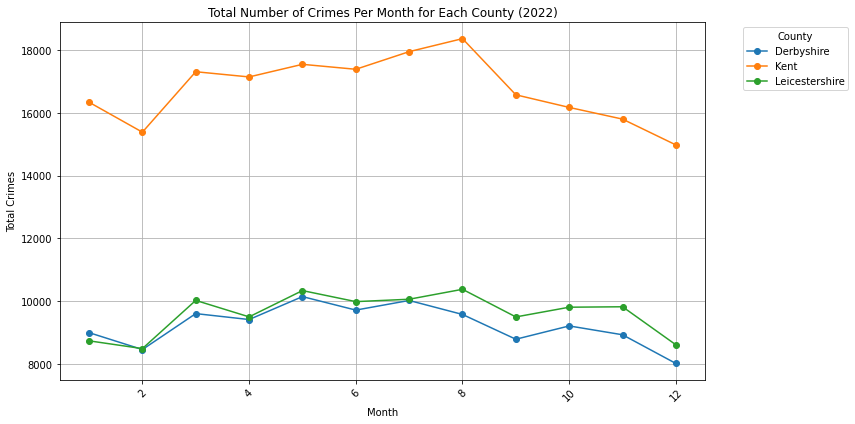

In [7]:
# Convert Spark DataFrame to Pandas DataFrame
monthly_crime_pd = monthly_crime_df.toPandas()

# Pivot the DataFrame to get counties as columns and months as rows
pivot_df = monthly_crime_pd.pivot(index='Month', columns='County', values='total_crimes')

# Create the line plot
plt.figure(figsize=(12, 6))

# Plot each county with different colors
for county in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[county], marker='o', label=county)

# Adding labels and title
plt.title('Total Number of Crimes Per Month for Each County (2022)')
plt.xlabel('Month')
plt.ylabel('Total Crimes')
plt.xticks(rotation=45)
plt.legend(title='County', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()


### Total Number of Each Crime Type for Each County

In this cell, we visualize the total number of crimes for each crime type across different counties using a bar plot.

1. **SQL Query**: We first define and execute an SQL query to calculate the total number of each crime type for each county. This is done by grouping the data by `County` and `Crime type` and counting the occurrences of each combination.

2. **Data Conversion**: The resulting Spark DataFrame is converted to a Pandas DataFrame (`crime_type_pd`) to facilitate easier plotting with Seaborn.

3. **Plotting Configuration**: We set the aesthetic style for the plots to "whitegrid" for better visibility of the bar chart.

4. **Bar Plot Creation**: A bar plot is created using `sns.barplot()`, where:
   - **X-axis**: Represents the total number of crimes.
   - **Y-axis**: Represents the types of crimes.
   - **Hue**: Differentiates the bars by county, allowing for a visual comparison of crime types across different regions.
   - **Dodge**: Ensures bars for different counties are displayed side by side for the same crime type.

5. **Labels and Title**: Appropriate labels for the x-axis, y-axis, and plot title are added for clarity.

6. **Legend**: A legend is displayed to indicate which colors correspond to which counties.

7. **Display the Plot**: Finally, the plot is displayed using `plt.tight_layout()` to optimize the layout before calling `plt.show()`.

This visualization provides insights into the distribution of various crime types across counties, highlighting trends and areas of concern in crime statistics.


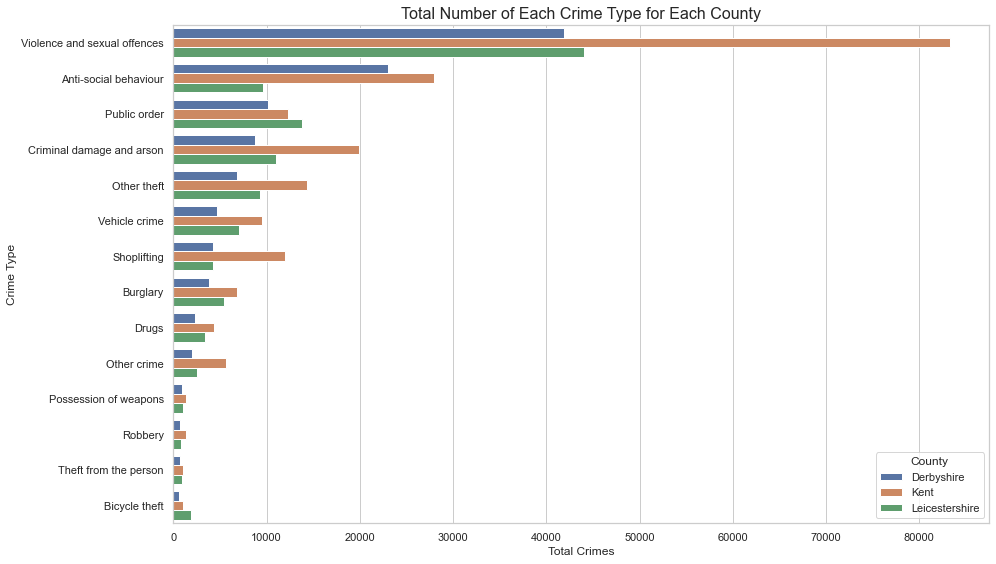

In [8]:
# Query to calculate total number of each crime type for each county
crime_type_query = """
SELECT County, 
       `Crime type`, 
       COUNT(*) AS total_crimes
FROM crime_data
GROUP BY County, `Crime type`
ORDER BY County, total_crimes DESC
"""

# Execute the query
crime_type_df = spark.sql(crime_type_query)

# Convert Spark DataFrame to Pandas DataFrame
crime_type_pd = crime_type_df.toPandas()

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(14, 8))

# Use the exact column name for 'Crime type'
bar_plot = sns.barplot(data=crime_type_pd, 
                        x='total_crimes', 
                        y='Crime type',  # Use the exact name as shown
                        hue='County', 
                        dodge=True)

# Adding labels and title
plt.title('Total Number of Each Crime Type for Each County', fontsize=16)
plt.xlabel('Total Crimes', fontsize=12)
plt.ylabel('Crime Type', fontsize=12)

# Show the legend
plt.legend(title='County')

# Show the plot
plt.tight_layout()
plt.show()



### Crime Type Breakdown by County

In this cell, we create pie charts to visualize the percentage breakdown of different crime types for each county in our dataset. 

1. **Unique Counties**: We first retrieve a list of unique counties from the `crime_type_pd` DataFrame.

2. **Subplot Configuration**: We determine the number of rows and columns needed for the pie charts. The number of columns is set to 2, and the number of rows is calculated based on the total number of counties to ensure all charts fit neatly within the figure.

3. **Figure Size**: The size of the figure is set to ensure that each pie chart is large enough to be clearly visible.

4. **Looping Through Counties**: We iterate over each county, filtering the data to obtain the relevant crime type data. For each county:
   - **Labels**: The labels for the pie chart are taken from the `Crime type` column.
   - **Sizes**: The sizes (or counts) of each crime type are derived from the `total_crimes` column.
   - A pie chart is created using `plt.pie()`, with percentage annotations for clarity. The title of each chart reflects the county being analyzed.

5. **Layout Adjustment**: Finally, we use `plt.tight_layout()` to optimize the spacing between subplots and display the pie charts using `plt.show()`.

This visualization allows us to easily compare the distribution of crime types across different counties, highlighting any significant variations in crime patterns.


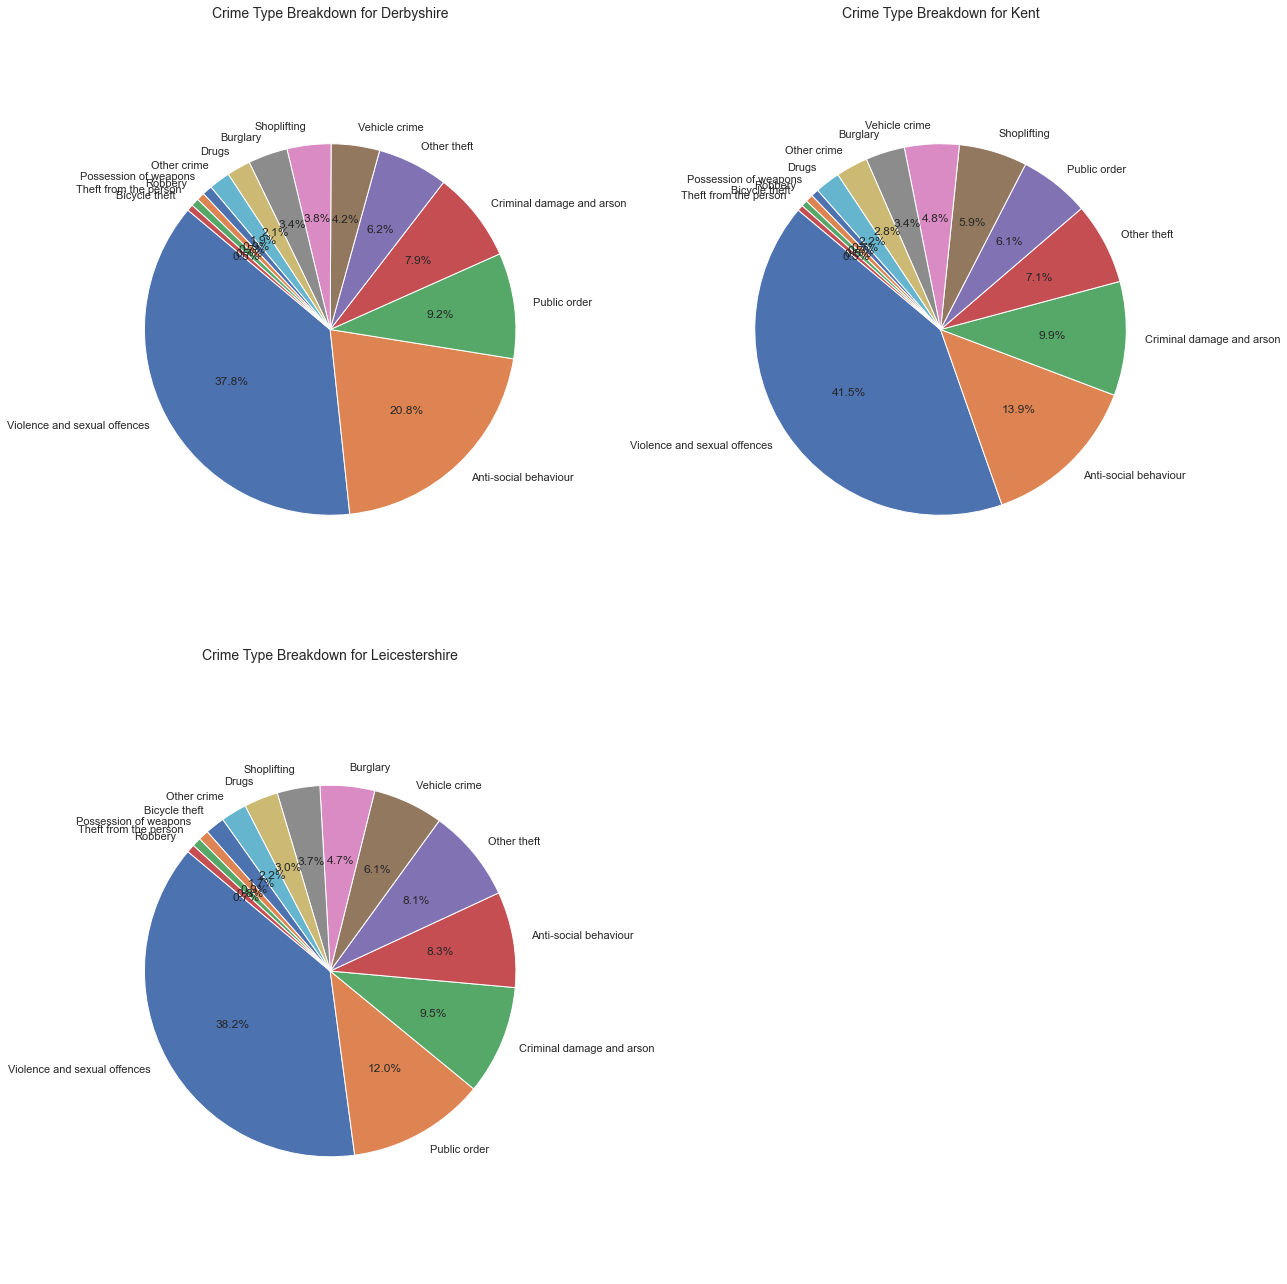

In [9]:
# Get a list of unique counties
counties = crime_type_pd['County'].unique()

# Calculate the number of rows and columns for subplots
num_counties = len(counties)
num_cols = 2  # Number of columns for the pie charts
num_rows = (num_counties + num_cols - 1) // num_cols  # Calculate rows needed

# Set up the figure size for the plots
plt.figure(figsize=(18, 9 * num_rows))

# Loop through each county and create a pie chart
for i, county in enumerate(counties):
    # Filter the data for the current county
    county_data = crime_type_pd[crime_type_pd['County'] == county]
    
    # Prepare data for the pie chart
    labels = county_data['Crime type']
    sizes = county_data['total_crimes']
    
    # Create a pie chart
    plt.subplot(num_rows, num_cols, i + 1)  # Adjust layout for subplots
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f'Crime Type Breakdown for {county}', fontsize=14)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Crime Analysis Summary for 2022

In 2022, Kent reported the highest total crimes with 200,945, followed by Leicestershire with 115,179 and Derbyshire with 110,805. 

Monthly crime trends show that Kent experienced consistent crime rates throughout the year, peaking at 18,365 in August. Leicestershire's highest monthly total was 10,332 in May, while Derbyshire's peak occurred in May with 10,140 crimes.

Violence and sexual offences were the most common crime type across all counties: 83,341 in Kent, 44,019 in Leicestershire, and 41,878 in Derbyshire. Conversely, the least common crimes included Theft from the person in Kent (1,007), Robbery in Leicestershire (811), and Bicycle theft in Derbyshire (604).


In [18]:
# Extract total crimes per county for 2022
total_crimes_per_county = crime_count_df.toPandas()

# Extract monthly crime data
monthly_crime_data = monthly_crime_df.toPandas()

# Extract highest and lowest crime months for each county
highest_lowest_months = result_df.toPandas()

# Extract most and least common crime types for each county
most_least_common_crimes = result_df.toPandas()

# Prepare the summary
summary = []

# Total crimes per county
summary.append("Total crimes per county in 2022:")
for index, row in total_crimes_per_county.iterrows():
    summary.append(f"- {row['County']}: {row['total_crimes']} total crimes")

# Monthly crime summary
summary.append("\nMonthly crime totals per county:")
for index, row in monthly_crime_data.iterrows():
    summary.append(f"- {row['County']} in Month {row['Month']}: {row['total_crimes']} crimes")

# Highest and lowest crime months
summary.append("\nMost and least common crime types by county:")
for index, row in highest_lowest_months.iterrows():
    summary.append(f"- {row['County']}: Most common crime type is {row['Most_Common_Crime_Type']} with {row['Most_Common_Crime_Count']} occurrences; "
                   f"Least common crime type is {row['Least_Common_Crime_Type']} with {row['Least_Common_Crime_Count']} occurrences.")


# Most and least common crime types
summary.append("\nMost and least common crime types by county:")
for index, row in most_least_common_crimes.iterrows():
    summary.append(f"- {row['County']}: Most common crime type is {row['Most_Common_Crime_Type']} with {row['Most_Common_Crime_Count']} occurrences; "
                   f"Least common crime type is {row['Least_Common_Crime_Type']} with {row['Least_Common_Crime_Count']} occurrences.")

# Convert summary list to string
summary_text = "\n".join(summary)

# Print the summary text to be used in a prompt for GPT
print(summary_text)


Total crimes per county in 2022:
- Kent: 200945 total crimes
- Leicestershire: 115179 total crimes
- Derbyshire: 110805 total crimes

Monthly crime totals per county:
- Derbyshire in Month 1: 8991 crimes
- Derbyshire in Month 2: 8452 crimes
- Derbyshire in Month 3: 9598 crimes
- Derbyshire in Month 4: 9409 crimes
- Derbyshire in Month 5: 10140 crimes
- Derbyshire in Month 6: 9710 crimes
- Derbyshire in Month 7: 10017 crimes
- Derbyshire in Month 8: 9571 crimes
- Derbyshire in Month 9: 8781 crimes
- Derbyshire in Month 10: 9205 crimes
- Derbyshire in Month 11: 8923 crimes
- Derbyshire in Month 12: 8008 crimes
- Kent in Month 1: 16338 crimes
- Kent in Month 2: 15383 crimes
- Kent in Month 3: 17310 crimes
- Kent in Month 4: 17144 crimes
- Kent in Month 5: 17546 crimes
- Kent in Month 6: 17388 crimes
- Kent in Month 7: 17950 crimes
- Kent in Month 8: 18365 crimes
- Kent in Month 9: 16574 crimes
- Kent in Month 10: 16172 crimes
- Kent in Month 11: 15799 crimes
- Kent in Month 12: 14976 crim